In [1]:
# DQN for alex_heater

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pickle
from datetime import datetime, date, timedelta
from random import randint
import time
import copy

import gym
from gym import Env, spaces

import torch
import random
from torch.autograd import Variable

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
"""Custom Environment that follows gym interface"""
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
                
        self.currentTime = '000030'
        self.initTemperature = 0
        self.currentTemperature = 0
        self.idealTemperature = 0
        N_DISCRETE_ACTIONS = 2 # 0= Off, 1=On
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.currentAction = 0
        self.roomTemp = 29
        self.highTemp = 100
        self.istraining = False
        
        # load models
        self.LR_model = pickle.load(open('linear_regression_nowaterusage.model', 'rb'))
        self.LR_s1 = pickle.load(open('linearregression_MinMaxScaler_nowaterusage.s1', 'rb'))
        self.LR_s2 = pickle.load(open('linearregression_MinMaxScaler_nowaterusage.s2', 'rb'))
        
        # penalties
        self.timePenalty = 0
        self.pricePenalty = 0
        self.comfortPenalty = 0

    def step(self, action):
        self.currentAction = action
        power = 1940 if action == 1 else 0.0
        curTemp = self.currentTemperature
        
        if(self.istraining):
            for i in range(10): # LR                
                transform = self.LR_s1.transform([[power, self.currentTemperature]])
                predictedTemperature = self.LR_model.predict([[transform[0][0], transform[0][1]]])
                self.currentTemperature = np.round(self.LR_s2.inverse_transform([predictedTemperature])[0][0], 2)
        else: # LR
            transform = self.LR_s1.transform([[power, self.currentTemperature]])
            predictedTemperature = self.LR_model.predict([[transform[0][0], transform[0][1] ]])
            self.currentTemperature = np.round(self.LR_s2.inverse_transform([predictedTemperature])[0][0], 2)
            
        newTemp = self.currentTemperature
        self.currentTemperature = curTemp        
        reward = self.calculateReward(newTemp)
        self.currentTemperature = newTemp
        
        # we will not drop water temperature below room temperature
        if(self.currentTemperature < self.roomTemp): self.currentTemperature = self.roomTemp
        # also, we will not increase water temp over highTemp = 100
        if(self.currentTemperature > self.highTemp): self.currentTemperature = self.highTemp
            
        self.currentTime = self.getnexttime()        
        return (int(self.currentTime), np.round(self.currentTemperature, 0), self.idealTemperature, 
                self.get_penalties()), reward, self.done(), []

    # re-initial the state of the environment
    def reset(self, istraining):
        self.istraining = istraining
        self.currentTemperature = randint(60, 75)
        self.currentTime = '000030'
        return (int(self.currentTime), np.round(self.currentTemperature, 0), self.idealTemperature, self.get_penalties())
    
    # adding one minute to the current time
    def getnexttime(self):
        newTime = datetime.strptime(str(date.today()) + ' ' + str(self.currentTime), '%Y-%m-%d %H%M%S') + timedelta(minutes=1)
        return newTime.strftime('%H%M%S')
    
    def done(self):        
        return True if(int(self.currentTime) > 235900
                      or self.currentTemperature < 5 or self.currentTemperature > 95) else False
    
    #calculate reward based on currentTemp and idealTemp
    def calculateReward(self, newTemp):
        idealTemp = self.idealTemperature - self.get_penalties()        
        if(newTemp < idealTemp):
            reward = newTemp - self.currentTemperature
            diff = abs(newTemp - idealTemp)
            coefficient = +1 if reward>0 else -1
            reward += coefficient * diff
        else:
            reward = self.currentTemperature - newTemp
            diff = abs(newTemp - idealTemp)
            coefficient = +1 if reward>0 else -1
            reward += coefficient * diff
        return round(reward, 1)
    
    # Render the environment to the screen
    def render(self, mode='human', close=False):        
        print(self.currentTime, " - ", self.idealTemperature, self.currentTemperature)
    
    # updating penalty parameters value
    def X_parameter(self, ideal_temp, time, price, comfort):
        self.idealTemperature = ideal_temp
        self.timePenalty = time
        self.pricePenalty = price
        self.comfortPenalty = comfort        
    
    # calculate penalty for the current state
    def get_penalties(self):
        if(int(self.currentTime) >= 220000 or int(self.currentTime) < 53000):
            tim = self.timePenalty[0]
        elif(int(self.currentTime) >= 53000 and int(self.currentTime) < 90000):
            tim = self.timePenalty[1]
        elif(int(self.currentTime) >= 90000 and int(self.currentTime) < 180000):
            tim = self.timePenalty[2]
        elif(int(self.currentTime) >= 180000 and int(self.currentTime) < 220000):
            tim = self.timePenalty[3]
        
        x_parameter = tim + self.pricePenalty + self.comfortPenalty
        return x_parameter

In [85]:
class DQN():
    # Deep Q Neural Network
    def __init__(self, state_dim=4, action_dim=2, hidden_dim=64, lr=0.001):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    
    # Update weights of the network given a state and reward
    def update(self, state, y):        
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # predict action based on the given state
    def predict(self, state):
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [86]:
# Expand DQN class with a replay memory functionality/.
class DQN_replay(DQN):
    def replay(self, memory, size=20, gamma=0.05):
        if len(memory) >= size:
            states = []
            targets = []
            # Sample a batch of experiences from the agent's memory
            batch = random.sample(memory, size)
            
            #Extract information from the data
            for state, action, next_state, reward, done in batch:
                states.append(state)
                # Predict q_values
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
     
                targets.append(q_values)
            self.update(states, targets)

In [87]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr=0.001):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    # makeing predicitons usiug the target network
    def target_predict(self, s):        
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    # Update target network with the model weights
    def target_update(self):        
        self.target.load_state_dict(self.model.state_dict())
        
    # the same replay memory functionality 
    # except getting q-values from the second network
    def replay(self, memory, size, gamma=.05):        
        if len(memory) >= size:            
            data = random.sample(memory, size)
            states = []
            targets = []
            
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:            
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)
            self.update(states, targets)

In [88]:
def q_learning(env, model, episodes, gamma=0.9, epsilon=0.3, eps_decay=0.99, replay=False, 
               replay_size=20, title = 'DQL', double=False, n_update=20, soft=False, verbose=True):
    
    final = []
    memory = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
        
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset(istraining=True)
        done = False
        total = 0

        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)            
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
            
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)

## Replay Memory

In [251]:
# gym environment
env = CustomEnv()
# Number of states
n_state = 4 # env.observation_space #.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 200
# Number of hidden nodes in the DQN
n_hidden = 64
# Learning rate
lr = 0.001

# Get DQN results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)

In [32]:
for ideal_temp in [70]:
    for tim in [[0, 0, 0, 0], [45, 0, 45, 0]]:
        for price in [0, 5, 10]:
            for comfort in [0, 5]:
                env.X_parameter(ideal_temp, tim, price, comfort)                
                replay = q_learning(env, dqn_replay, episodes=20, gamma=.05, epsilon=0.1, replay=True, title='DQL with Replay')

In [40]:
# pickle.dump(dqn_replay, open('DQN_ReplayMemory.dump', 'wb'))
dqn_replay = pickle.load(open('DQN_ReplayMemory.dump', 'rb'))

In [74]:
env = CustomEnv()

#pre-set parameters
ideal_temp = 70
time = [0, 0, 0, 0]
price = last_price_penalty = 0 # 10
comfort = 0 # 5
env.X_parameter(ideal_temp, time, price, comfort)

#loading power price
file = '''daily_power_price.csv'''
power_price = pd.read_csv(file)
power_price.index = power_price.time

def get_price_penalty(time):
    price = power_price[power_price['time']==int(time)].price.values[0]    
    if(price>0 and price<100): return 0
    if(price>100 and price<200): return 5
    if(price>200): return 10
    
result = []
current_state = env.reset(istraining=False)
done = False

while not done:    
    t = str(current_state[0])
    while len(t)<6: t="0"+t
    currhour = t[0][0:2]
    new_price_penalty = get_price_penalty(currhour)
    
    if(new_price_penalty != last_price_penalty):
        print_penalty = current_state[3]
        print_penalty -= last_price_penalty
        print_penalty += new_price_penalty
        last_price_penalty = new_price_penalty
        current_state = (current_state[0],current_state[1],current_state[2],print_penalty)
        env.X_parameter(ideal_temp, time, new_price_penalty, comfort)

    action = np.argmax(dqn_replay.predict(current_state).tolist())
    result.append([current_state, action])
    
    observation, reward, done, info = env.step(action)
    current_state = observation

    if done:
        break

In [75]:
temps = [item[0][1] for item in result]
penalty = [item[0][3] for item in result]
actions = [item[1] for item in result]
xtim = [i/60 for i in range(len(result))]

In [76]:
# Raw data of one particular day
file = '''RPT1106_data_1440.csv'''
newdata = pd.read_csv(file)
x = [i/60 for i in range(1440)]

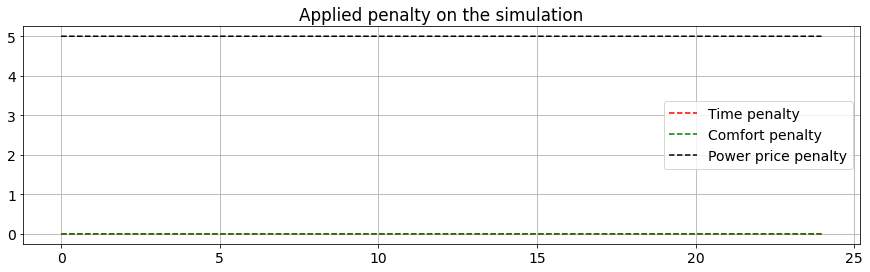

In [77]:
timepenalty  = [time[0] for i in range(330)]
[timepenalty.append(time[1]) for i in range(210)]
[timepenalty.append(time[2]) for i in range(9*60)]
[timepenalty.append(time[3]) for i in range(6*60)]

comfortpenalty  = [comfort for i in range(len(penalty))]
penalty = [penalty[i] - (timepenalty[i] + comfort) for i in range(len(penalty))]

plt.rcParams["figure.figsize"] = (15, 4)
plt.plot(x, timepenalty, 'r--', label='Time penalty')
plt.plot(x[:1439], comfortpenalty, 'g--', label='Comfort penalty')
plt.plot(x[:1439], penalty, 'k--', label='Power price penalty')
plt.title('Applied penalty on the simulation')
plt.grid()
plt.legend()

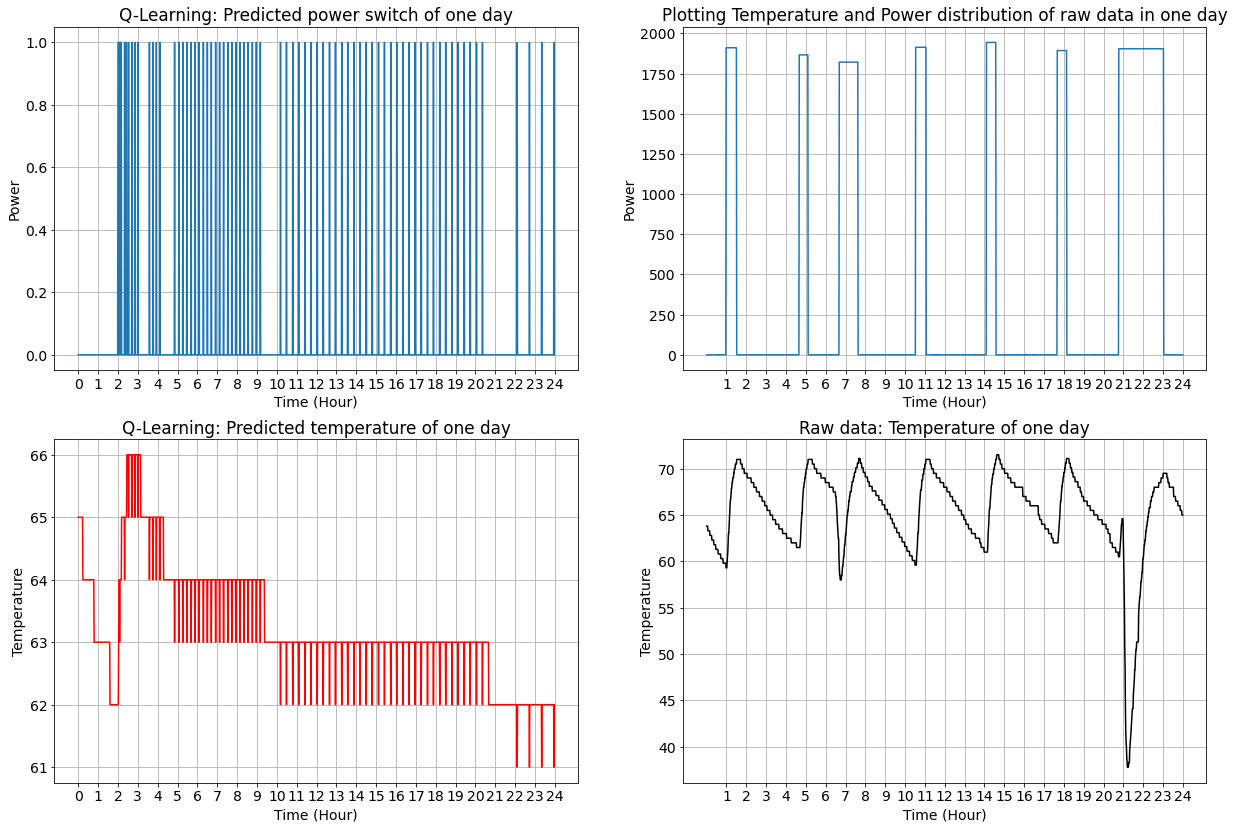

In [78]:
plt.rcParams.update({'font.size': 14})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, gridspec_kw=dict(left=0.1, right=0.9,
                                        bottom=0.1, top=2.2), figsize=(20, 5))

ax1.plot(xtim, actions, '-', label="Power switch")
ax1.set_xticks(np.arange(0, 25, 1))
ax1.set_xlabel('Time (Hour)')
ax1.set_ylabel('Power')
ax1.set_title("Q-Learning: Predicted power switch of one day")
ax1.grid()

ax3.plot(xtim, temps, 'r-', label="Temperature")
ax3.set_xticks(np.arange(0, 25, 1))
ax3.set_xlabel('Time (Hour)')
ax3.set_ylabel('Temperature')
ax3.set_title("Q-Learning: Predicted temperature of one day")
ax3.grid()

ax2.set_title("Plotting Temperature and Power distribution of raw data in one day")
ax2.plot(x, newdata.power[0:1440], '-', label='Power')
ax2.set_xticks(np.arange(1, 25, 1))
ax2.set_ylabel('Power')
ax2.set_xlabel('Time (Hour)')
ax2.grid()

ax4.plot(x, newdata.temperature[0:1440], 'k-', label='Temperature')
ax4.set_xticks(np.arange(1, 25, 1))
ax4.set_title("Raw data: Temperature of one day")
ax4.set_xlabel('Time (Hour)')
ax4.set_ylabel('Temperature')
ax4.grid()

plt.show()

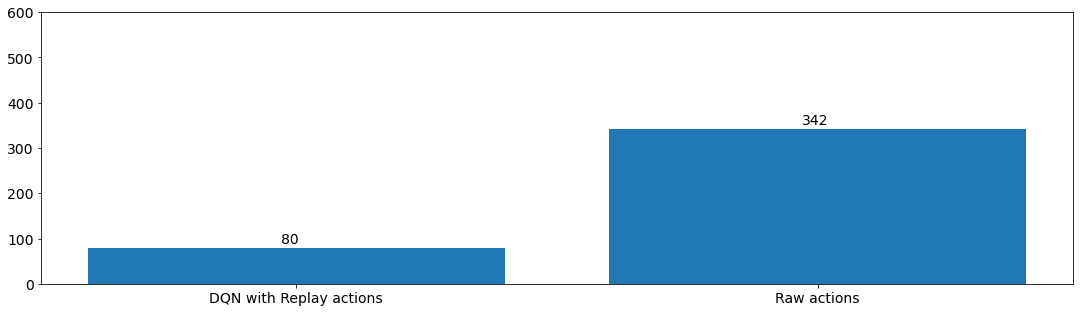

In [80]:
pre_action = sum(actions)
raw_action = sum([0 if item<250 else 1 for item in newdata.power[0:1440]])

plt.rcParams["figure.figsize"] = (18.5, 5)
z=['DQN with Replay actions', 'Raw actions']
y=[pre_action, raw_action]
plt.bar(z, y)
plt.yticks(np.arange(0, 601, 100))

for i, v in enumerate(z):
    plt.text(i-0.03, y[i]+10 , y[i])

## Double DQN

In [83]:
# gym environment
env = CustomEnv()
# Number of states
n_state = 4 # env.observation_space #.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 200
# Number of hidden nodes in the DQN
n_hidden = 64
# Learning rate
lr = 0.001
# Get DQN results
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)

In [89]:
for ideal_temp in [70]:
    for tim in [[0, 0, 0, 0], [45, 0, 45, 0]]:
        for price in [0, 5, 10]:
            for comfort in [0, 5]:
                env.X_parameter(ideal_temp, tim, price, comfort)                
                double = q_learning(env, dqn_double, episodes=20, gamma=.05, epsilon=0.1, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)

In [90]:
# pickle.dump(dqn_double, open('dqn_double_3.dump', 'wb'))
dqn_double = pickle.load(open('dqn_double_3.dump', 'rb'))

In [91]:
env = CustomEnv()

#pre-set parameters
ideal_temp = 70
time = [0, 0, 0, 0]
price = last_price_penalty = 0 # 10
comfort = 0 # 5
env.X_parameter(ideal_temp, time, price, comfort)

#loading power price
file = '''daily_power_price.csv'''
power_price = pd.read_csv(file)
power_price.index = power_price.time

def get_price_penalty(time):
    price = power_price[power_price['time']==int(time)].price.values[0]    
    if(price>0 and price<100): return 0
    if(price>100 and price<200): return 5
    if(price>200): return 10
    
result = []
current_state = env.reset(istraining=False)
done = False

while not done:    
    t = str(current_state[0])
    while len(t)<6: t="0"+t
    currhour = t[0][0:2]
    new_price_penalty = get_price_penalty(currhour)
    
    if(new_price_penalty != last_price_penalty):
        print_penalty = current_state[3]
        print_penalty -= last_price_penalty
        print_penalty += new_price_penalty
        last_price_penalty = new_price_penalty
        current_state = (current_state[0],current_state[1],current_state[2],print_penalty)
        env.X_parameter(ideal_temp, time, new_price_penalty, comfort)

    action = np.argmax(dqn_double.predict(current_state).tolist())
    result.append([current_state, action])
    
    observation, reward, done, info = env.step(action)
    current_state = observation

    if done:
        break

In [92]:
temps = [item[0][1] for item in result]
penalty = [item[0][3] for item in result]
actions = [item[1] for item in result]
xtim = [i/60 for i in range(len(result))]

In [93]:
# Raw data of one particular day
file = '''RPT1106_data_1440.csv'''
newdata = pd.read_csv(file)
x = [i/60 for i in range(1440)]

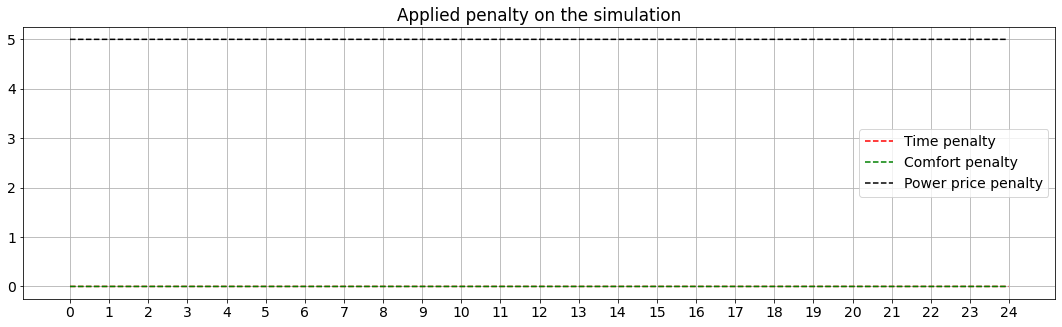

In [96]:
timepenalty  = [time[0] for i in range(330)]
[timepenalty.append(time[1]) for i in range(210)]
[timepenalty.append(time[2]) for i in range(9*60)]
[timepenalty.append(time[3]) for i in range(6*60)]

comfortpenalty  = [comfort for i in range(len(penalty))]
penalty = [penalty[i] - (timepenalty[i] + comfort) for i in range(len(penalty))]
plt.plot(x, timepenalty, 'r--', label='Time penalty')
plt.plot(x[:1439], comfortpenalty, 'g--', label='Comfort penalty')
plt.plot(x[:1439], penalty, 'k--', label='Power price penalty')
plt.title('Applied penalty on the simulation')
plt.xticks(np.arange(0, 25, 1))
plt.grid()
plt.legend()

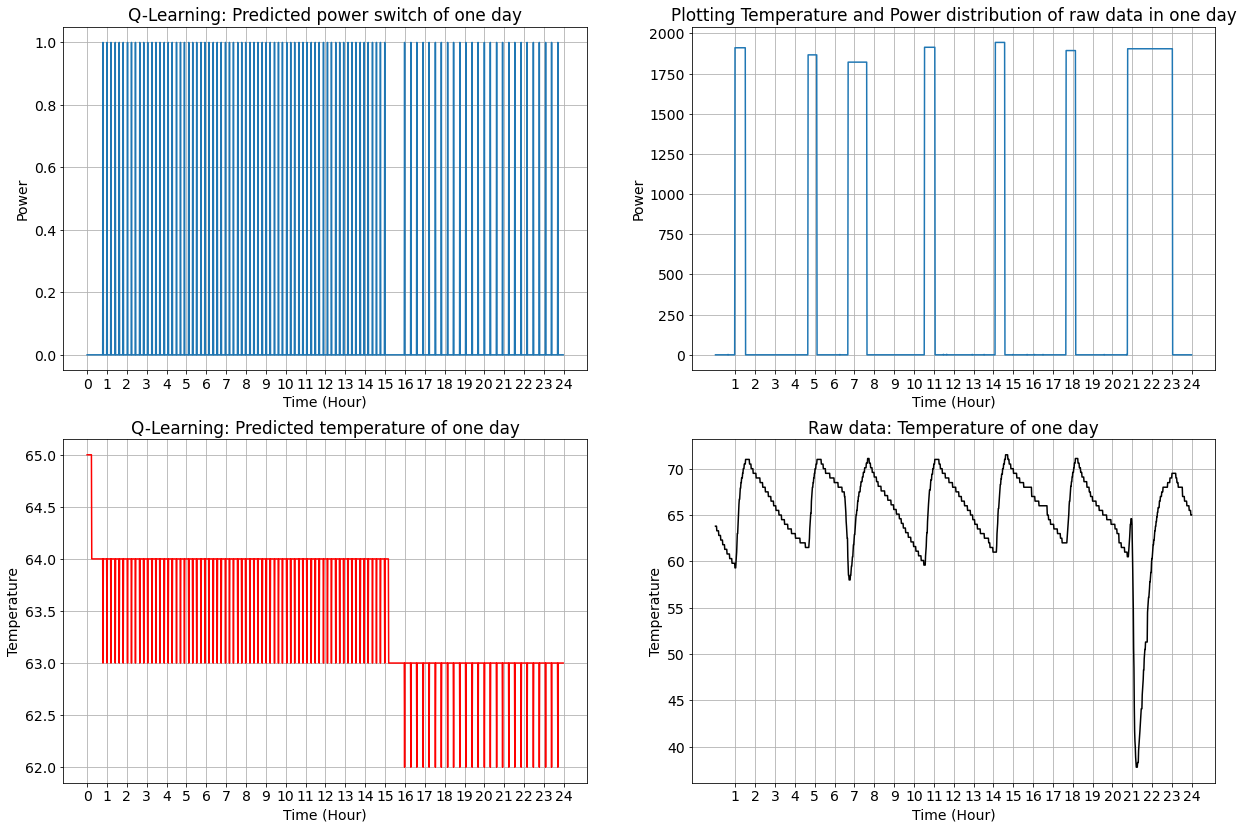

In [97]:
plt.rcParams.update({'font.size': 14})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, gridspec_kw=dict(left=0.1, right=0.9,
                                        bottom=0.1, top=2.2), figsize=(20, 5))

ax1.plot(xtim, actions, '-', label="Power switch")
ax1.set_xticks(np.arange(0, 25, 1))
ax1.set_xlabel('Time (Hour)')
ax1.set_ylabel('Power')
ax1.set_title("Q-Learning: Predicted power switch of one day")
ax1.grid()

ax3.plot(xtim, temps, 'r-', label="Temperature")
ax3.set_xticks(np.arange(0, 25, 1))
ax3.set_xlabel('Time (Hour)')
ax3.set_ylabel('Temperature')
ax3.set_title("Q-Learning: Predicted temperature of one day")
ax3.grid()

ax2.set_title("Plotting Temperature and Power distribution of raw data in one day")
ax2.plot(x, newdata.power[0:1440], '-', label='Power')
ax2.set_xticks(np.arange(1, 25, 1))
ax2.set_ylabel('Power')
ax2.set_xlabel('Time (Hour)')
ax2.grid()

ax4.plot(x, newdata.temperature[0:1440], 'k-', label='Temperature')
ax4.set_xticks(np.arange(1, 25, 1))
ax4.set_title("Raw data: Temperature of one day")
ax4.set_xlabel('Time (Hour)')
ax4.set_ylabel('Temperature')
ax4.grid()

plt.show()

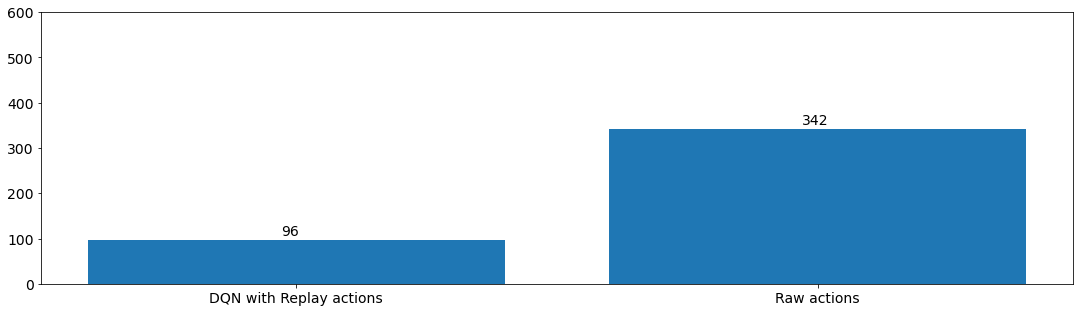

In [98]:
pre_action = sum(actions)
raw_action = sum([0 if item<250 else 1 for item in newdata.power[0:1440]])

plt.rcParams["figure.figsize"] = (18.5, 5)
z=['DQN with Replay actions', 'Raw actions']
y=[pre_action, raw_action]
plt.bar(z, y)
plt.yticks(np.arange(0, 601, 100))

for i, v in enumerate(z):
    plt.text(i-0.03, y[i]+10 , y[i])